In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


#  SynthBrainGrow: Synthetic Diffusion Brain Aging for Longitudinal MRI Data Generation in Young People
<br>
<br>
This is a demo of synthetic diffusion 2 year ageing using MRI guidance proposed in [1].<br>
Method inspired by [2,3,4].
<br>
<br>
[1] - Zapaishchykova et al. "SynthBrainGrow: Synthetic Diffusion Brain Aging for Longitudinal MRI Data Generation in Young People", https://arxiv.org/pdf/2405.00682 <br>
[2] - Wolleb et al. "Diffusion Models for Implicit Image Segmentation Ensembles", https://arxiv.org/abs/2112.03145<br>
[3] - Waibel et al. "A Diffusion Model Predicts 3D Shapes from 2D Microscopy Images", https://arxiv.org/abs/2208.14125<br>
[4] - Durrer et al. "Diffusion Models for Contrast Harmonization of Magnetic Resonance Images", https://aps.arxiv.org/abs/2303.08189



## Setup environment
This is an extension of MONAI Generative repository. To begin, clone the  
'pip install git+https://github.com/Project-MONAI/GenerativeModels.git'
Next, copy this notebook to the GenerativeModels/tutorials/generative/image_to_image_translation folder. 

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn


## Setup imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0" #change this as needed
import tempfile
import time
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import monai
import pandas as pd
import scipy.ndimage as ndimage

from generative.inferers import DiffusionInferer
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddpm import DDPMScheduler
from monai.data import Dataset, DataLoader

from preprocess_long579 import preprocess

#torch.multiprocessing.set_sharing_strategy("file_system")
print_config()
set_determinism(42)

MONAI version: 1.4.dev2344
Numpy version: 1.24.1
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 20c983ddade8b1386a56ddfe8db1c6b071913d33
MONAI __file__: /home/<username>/anaconda3/envs/py39_torch/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
scipy version: 1.11.3
Pillow version: 9.3.0
Tensorboard version: 2.15.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu118
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.3
pandas version: 2.1.2
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.8.0
pynrrd version: 1.0.0
clearml version: 1.13.2rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies




# Preprocessing of the Data
Since ABCD dataset needs to be requested https://nda.nih.gov/abcd, we demonstrate the feasibility of the pipeline on the OpenNeuro Dataset "A longitudinal neuroimaging dataset on language processing in children ages 5, 7, and 9 years old" https://openneuro.org/datasets/ds003604/versions/1.0.7. We will only use pairs of images that were recorded at 7-9 years old, since method was initially trained on 8-16 years old subjects from ABCD dataset. Note: since this dataset requires N4 debiasing, it will take a while to preprocess all.


In [2]:
import os
from preprocess_long579 import preprocess
path_to_long579_data = 'ds003604-download' # https://openneuro.org/datasets/ds003604/versions/1.0.7
path_to_processed_data = 'data/'
path_to_hdbet='/media/sda/Anna/brain_age/HDBET'

if not os.path.exists(path_to_processed_data):
    os.mkdir(path_to_processed_data)

output_df = preprocess(path_to_long579_data, path_to_processed_data,path_to_hdbet,0)
#save to csv
output_df.to_csv('data/preprocessed_pairs.csv',index=False,header=None)
print(output_df.head())

Module imported successfully.
   participant_id   birthdate   sex  handedness_ses-5  handedness_ses-7  \
5            5007  1809-06-19  Male               5.0               5.0   

   handedness_ses-9 ses-5_date_ST ses-7_date_ST ses-9_date_ST  
5               5.0    1814-07-04    1816-08-14    1818-08-21  
sub-5007
Registered  sub-5007_7
Registered  sub-5007_9
Registered
Running hdbet
File: data/registered/sub-5007_7.nii.gz
preprocessing...
image shape after preprocessing:  (126, 155, 131)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
Coregistering and denoising
Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Step too small after 55 iterations. Current step (6.10352e-05) is less than minimum step (0.0001).
[1 7 6] [65 71 70]
[1 7 6] [65 71 70]
                                     0                                    1
0  data/preprocessed/sub-5007_7.nii.gz  data/preprocessed/sub-5007_9.nii.gz


In [3]:
class ABCDDataset(Dataset):
    # note: to speed everything up, data must be processed beforehand
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        item = {'image': None, 'label': None}
        item['image'] = nib.load(self.data[index]['image']).get_fdata()
        item['image'] = np.array(item['image'], dtype=np.float32)
        
        item['label'] = nib.load(self.data[index]['label']).get_fdata()
        item['label'] = np.array(item['label'], dtype=np.float32)
        if self.transform:
            item = self.transform(item)
        return item


In [4]:
def prepare_df(df, train_transforms, batch_size=8):
    set_determinism(seed=0)
    _files  = []
    for i in range(len(df)):
        row = df.iloc[i]    
        _files.append({"image": row[0], "label": row[1]})
    
    ds = ABCDDataset(data = _files, transform=train_transforms)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return loader

# to speed it up, transforms are applied to the dataset before caching in preprocess_all_brains.py
train_transforms = transforms.Compose(
    [
        transforms.EnsureChannelFirstd(keys=["image","label"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        ]
)


In [5]:
#format of training.csv: 
#path_to_image1.nii.gz,path_to_image2.nii.gz
df = pd.read_csv('data/preprocessed_pairs.csv',header=None)

test_list_len = int(len(df))
print("Total n of pairs",len(df))

test_loader = prepare_df(df,train_transforms)

Total n of pairs 1


In [6]:
## define model 
device = torch.device("cuda")
model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=2,
    num_head_channels=64,
    with_conditioning=False,
)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(2, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (

In [7]:
n_epochs = 4000
val_interval = 100
epoch_loss_list = []
val_epoch_loss_list = []

scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler)

scaler = GradScaler()
total_start = time.time()


### Model training of the Diffusion Model<br>
We train our diffusion model for 4000 epochs.\
In every step, we concatenate the original MR image to the noisy segmentation mask, to predict a slightly denoised segmentation mask.\
This is described in Equation 7 of the paper https://arxiv.org/pdf/2112.03145.pdf.

In [8]:
model.load_state_dict(torch.load("./brainmodel.pt"))
model.eval()

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(2, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (


# Sampling of a new brain an input image of the validation set<br>

Starting from random noise, we want to generate a brain MR image of our validation set.\
Due to the stochastic generation process, we can sample an ensemble of n different MR images.\
First, we pick an image of our validation set, and check the ground truth brain.

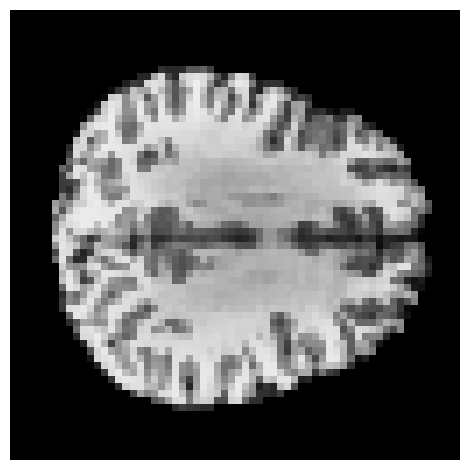

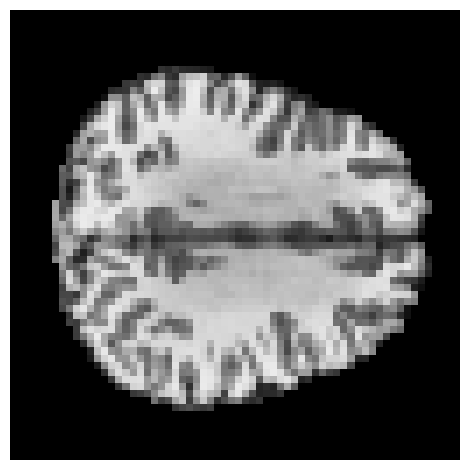

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(2, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (

In [9]:
idx = 0
_files=[]
for i in range(len(df)):
    row = df.iloc[i]   
    _files.append({"image": row[0], "label": row[1]})
    ds = ABCDDataset(data = _files, transform=train_transforms)

data = ds[idx]
inputimg = data["image"][0, ...]  # Pick an input slice of the validation set to be segmented
inputlabel = data["label"][0, ...]  # Check out the ground truth label mask. If it is empty, pick another input slice.


plt.figure("input" + str(inputlabel))
plt.imshow(inputimg[:,:,32], vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

plt.figure("input" + str(inputlabel))
plt.imshow(inputlabel[:,:,32], vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()


model.eval()

In [10]:
#len(test_df)
results_path = os.path.join(path_to_processed_data, 'output')
if not os.path.exists(results_path):
    os.mkdir(results_path)
        
for k in range(0,len(df)):
    print(k)
    data = ds[k]
    inputimg = data["image"][0, ...]  # Pick an input slice of the validation set to be segmented
    inputlabel = data["label"][0, ...]  # Check out the ground truth label mask. If it is empty, pick another input slice.
   
    input_img = inputimg[None, None, ...].to(device)
    noise = torch.randn_like(input_img).to(device)
    current_img = noise  # for the segmentation mask, we start from random noise.
    combined = torch.cat((input_img, noise), dim=1)  # We concatenate the input brain MR image to add anatomical information.

    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    chain = torch.zeros(current_img.shape)
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(
                    model_output, t, current_img
                )  # this is the prediction x_t at the time step t
                if t % 100 == 0:
                    chain = torch.cat((chain, current_img.cpu()), dim=-1)
                combined = torch.cat(
                    (input_img, current_img), dim=1
                )  # in every step during the denoising process, the brain MR image is concatenated to add anatomical information

    im_arr = current_img[0][0].cpu().numpy() 
    im_arr = ndimage.zoom(im_arr, 2, order=3)
    img = nib.Nifti1Image(im_arr, np.eye(4))
    nib.save(img, os.path.join(results_path,'diffusion_'+str(k)+'.nii.gz'))

0


100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.53it/s]


In [11]:
df_files = pd.DataFrame(_files)
df_files.to_csv(os.path.join(results_path,'labels.csv'))

## Uncertainty estimation using stohastic predictions

Then we set the number of samples in the ensemble n. \
Starting from the input image (which ist the brain MR image), we follow Algorithm 1 of the paper "Diffusion Models for Implicit Image Segmentation Ensembles" (https://arxiv.org/pdf/2112.03145.pdf) n times.\
This gives us an ensemble of n different predicted brain images.

In [12]:
n = 10
input_img = inputimg[None, None, ...].to(device)
ensemble = []
for k in range(n):
    noise = torch.randn_like(input_img).to(device)
    current_img = noise  # for the segmentation mask, we start from random noise.
    combined = torch.cat(
        (input_img, noise), dim=1
    )  # We concatenate the input brain MR image to add anatomical information.

    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    chain = torch.zeros(current_img.shape)
    for t in progress_bar:  # go through the noising process
        with autocast(enabled=False):
            with torch.no_grad():
                model_output = model(combined, timesteps=torch.Tensor((t,)).to(current_img.device))
                current_img, _ = scheduler.step(
                    model_output, t, current_img
                )  # this is the prediction x_t at the time step t
                if t % 100 == 0:
                    chain = torch.cat((chain, current_img.cpu()), dim=-1)
                combined = torch.cat(
                    (input_img, current_img), dim=1
                )  # in every step during the denoising process, the brain MR image is concatenated to add anatomical information

    ensemble.append(current_img)  # this is the output of the diffusion model after T=1000 denoising steps

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.13it/s]


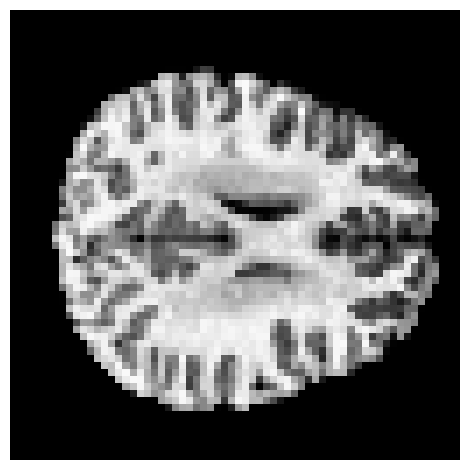

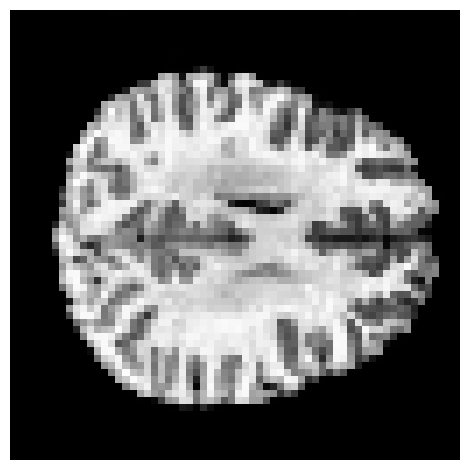

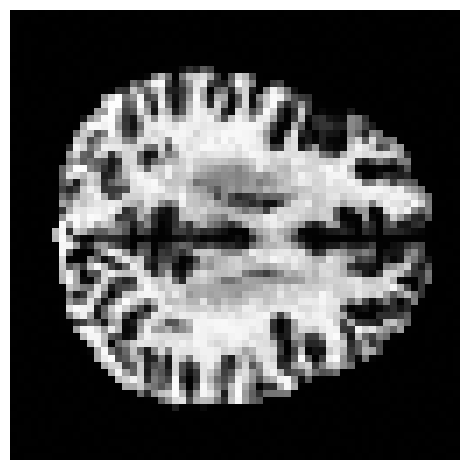

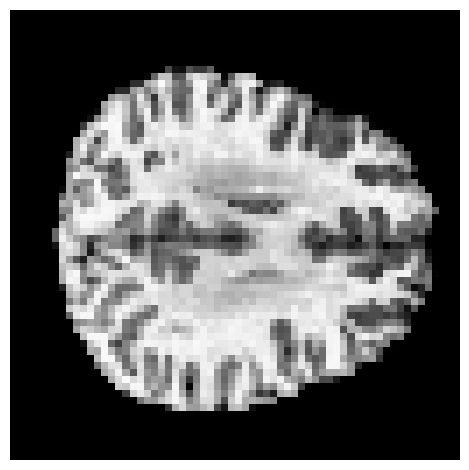

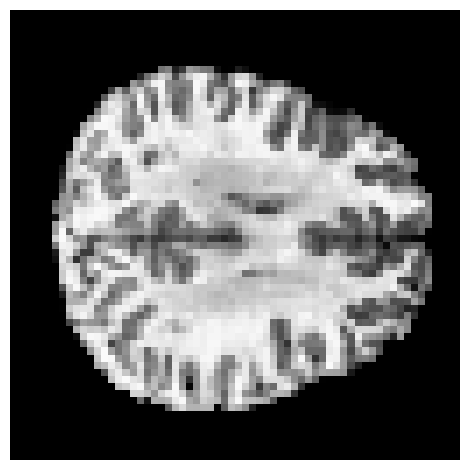

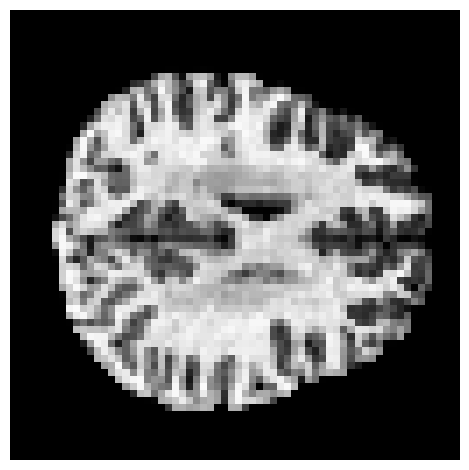

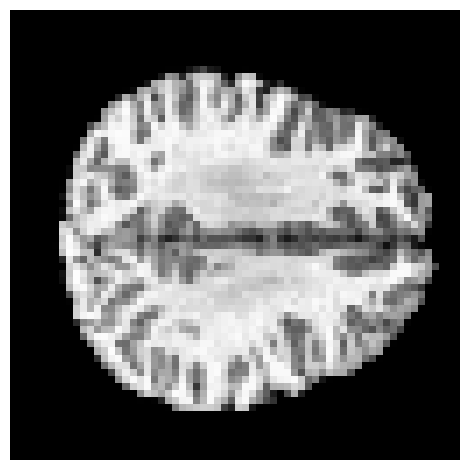

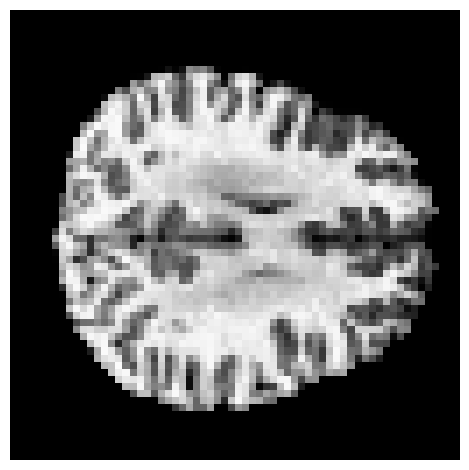

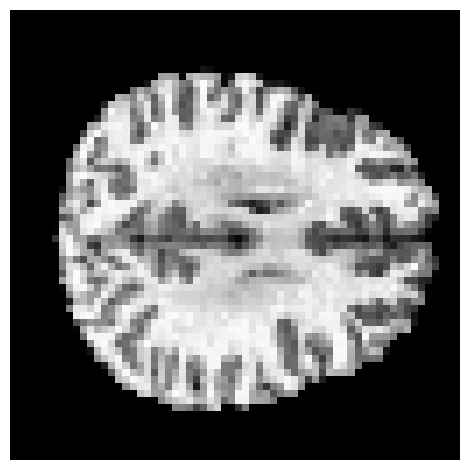

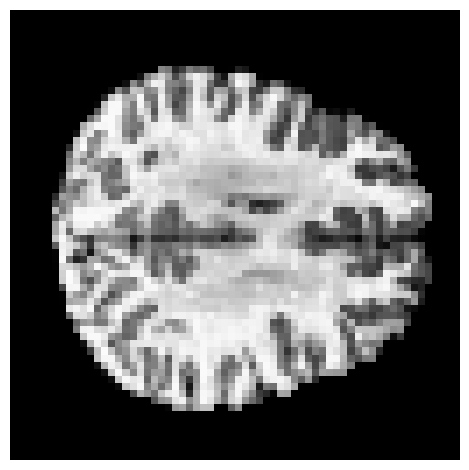

In [13]:
for i in range(len(ensemble)):
    plt.figure("pred" + str(i))
    plt.imshow(ensemble[i].cpu()[0,0,:,:,32], vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

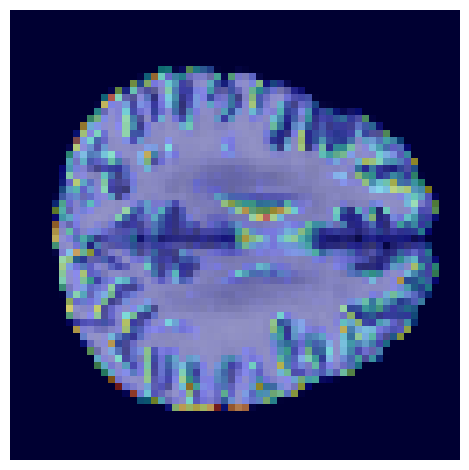

In [14]:
import matplotlib.pyplot as plt
import torch

E = torch.cat(ensemble).float()

var = torch.var(E, dim=0) 
mean = torch.mean(E, dim=0)

img = nib.Nifti1Image(var[0,...].cpu().numpy(), np.eye(4))
nib.save(img, 'variance.nii.gz')

img = nib.Nifti1Image(mean[0,...].cpu().numpy(), np.eye(4))
nib.save(img, 'in.nii.gz')

slice_to_plot = 32
m = mean[0,:,:,slice_to_plot].cpu()
v = var[0,:,:,slice_to_plot].cpu()

fig, ax = plt.subplots()
ax.imshow(m, vmin=0, vmax=1, cmap="gray")
ax.imshow(v, cmap="jet", alpha=0.4)
ax.axis("off")
plt.tight_layout()
plt.show()